In [ ]:
import pandas as pd
import re
import string
#!pip install pymorphy3
import pymorphy3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

  Using cached pymorphy3-2.0.6-py3-none-any.whl.metadata (2.4 kB)
  Using cached dawg2_python-0.9.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached pymorphy3_dicts_ru-2.4.417150.4580142-py2.py3-none-any.whl.metadata (2.0 kB)
Using cached pymorphy3-2.0.6-py3-none-any.whl (53 kB)
Using cached dawg2_python-0.9.0-py3-none-any.whl (9.3 kB)
Using cached pymorphy3_dicts_ru-2.4.417150.4580142-py2.py3-none-any.whl (8.4 MB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#на сервере
with open('/content/drive/MyDrive/Colab Notebooks/Toxic/dataset.txt','r') as f:
    lines=f.readlines()
print(lines[:10])
# вопрос по верности разметки. ("2 августа поздно вечером ..."),("потомучто,не было разносчиков заразы из-за границы. а у нас всё было под контролем и комары и клещи."),("")
# надо перепроверить насколько это возможно


In [ ]:
#локально
file_path_data = r"C:\Users\Дрон\Desktop\МЛ\dataset_cleaned.csv"

with open(file_path_data, 'r', encoding='utf-8') as f:
    lines = f.readlines()

print(lines[:10])

['text,label\n', 'скотина что сказать,1\n', 'я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином на пустыре бежала кошка похожего окраса может я и ошиблась но необычный окрас бросился в глаза,0\n', 'очередной лохотрон зачем придумывать очередной налог на воздух если можно обьявить инсульт и грипп пандемией и лихо на придурках зарабатывать годами на штрафах фейковых вакцинах всевозможных платных тестах продажей масок и перчаток по баснословным ценам самое смешное что бараны блеют и верят пастуху телевизору живут как под гипнозом не думая не глядя по сторонам,0\n', 'ретро дежавю сложно понять чужое сердце лиш ощутить музыкой видимо,0\n', 'а когда мы статус агрогородка получили,0\n', 'августа поздно вечером нашли вот такую потеряшку в районе высоток на победе девочка явно домашняя в новом ошейнике обращаться,0\n', 'вчера надыбала новые стикеры uaecfabs,0\n', 'заколоть этого плешивого урода что бы крякнул как селезень гандон штопанный всю вакцину ему в бошку чт

In [ ]:
negative_labels=['__label__INSULT','__label__THREAT','__label__OBSCENITY','__label__INSULT,__label__THREAT','__label__INSULT,__label__OBSCENITY','__label__INSULT,__label__OBSCENITY,__label__THREAT','__label__OBSCENITY,__label__THREAT']
normal_labels=['__label__NORMAL']

In [ ]:

def clean_text(text):
  text=text.lower()
  text=re.sub(r'http\S+|www\S+|bit.ly\S+', '', text)
  text=re.sub(r'@\S+', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text


In [ ]:

df = pd.read_csv(r"C:\Users\Дрон\Desktop\МЛ\dataset_cleaned.csv")
print(f"Загружено строк: {len(df)}")
print(df.head())

Загружено строк: 248288
                                                text  label
0                                скотина что сказать      1
1  я сегодня проезжала по рабочей и между домами ...      0
2  очередной лохотрон зачем придумывать очередной...      0
3  ретро дежавю сложно понять чужое сердце лиш ощ...      0
4             а когда мы статус агрогородка получили      0


In [ ]:
morph=pymorphy3.MorphAnalyzer()
df = df.dropna(subset=['text'])
def lemmas_text (text):
  words=text.split()
  lemmas=[morph.parse(word)[0].normal_form for word in words]
  return ' '.join(lemmas)




In [ ]:
from tqdm import tqdm

# 1. Загрузка
df = pd.read_csv(r"C:\Users\Дрон\Desktop\МЛ\dataset_cleaned.csv")

# Принудительно чистим названия колонок
df.columns = df.columns.str.strip()

# ПРОВЕРКА: Если колонки 'text_lemmas' еще нет, создаем её
if 'text_lemmas' not in df.columns:
    print("⏳ Колонки с леммами нет, запускаю лемматизацию...")
    # Убедись, что функция lemmas_text определена выше!
    tqdm.pandas()
    df['text_lemmas'] = df['text'].astype(str).progress_apply(lemmas_text)
else:
    print("✅ Колонка 'text_lemmas' уже есть в файле, пропускаю шаг.")

print(df[['text', 'text_lemmas']].head())

⏳ Колонки с леммами нет, запускаю лемматизацию...


100%|████████████████████████████████████████████████████████████████████████| 248288/248288 [03:15<00:00, 1269.93it/s]

                                                text  \
0                                скотина что сказать   
1  я сегодня проезжала по рабочей и между домами ...   
2  очередной лохотрон зачем придумывать очередной...   
3  ретро дежавю сложно понять чужое сердце лиш ощ...   
4             а когда мы статус агрогородка получили   

                                         text_lemmas  
0                                скотина что сказать  
1  я сегодня проезжать по рабочий и между дом сни...  
2  очередной лохотрон зачем придумывать очередной...  
3  ретро дежавю сложно понять чужое сердце лиш ощ...  
4             а когда мы статус агрогородок получить  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemmas'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label'])

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=50000,
    min_df=2
)

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose()
final_table = metrics_df.loc[['0', '1', 'accuracy'], ['precision', 'recall', 'f1-score', 'support']]
print("Logistic Regression")
print(final_table)

Logistic Regression
          precision    recall  f1-score       support
0          0.975646  0.962737  0.969148  40737.000000
1          0.839535  0.890259  0.864153   8921.000000
accuracy   0.949716  0.949716  0.949716      0.949716


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [ ]:
svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=2000)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
metrics_svm_df = pd.DataFrame(report_svm).transpose()
metrics_svm_df.index = metrics_svm_df.index.astype(str)

final_svm_table = metrics_svm_df.loc[['0', '1', 'accuracy'], ['precision', 'recall', 'f1-score', 'support']]

print("SVM:")
print(final_svm_table)

SVM:
          precision    recall  f1-score       support
0          0.975088  0.962737  0.968873  40737.000000
1          0.839144  0.887681  0.862730   8921.000000
accuracy   0.949253  0.949253  0.949253      0.949253


In [ ]:
#RuBERT
#IlyaGusev/rubertconv_toxic_clf более хорошая моделька,классификация toxic/no на рускком корпусе

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
#from google.colab import drive
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt





In [ ]:



file_path = r"/content/drive/MyDrive/Colab Notebooks/Toxic/dataset_cleaned.csv"
df = pd.read_csv(file_path)


df = df.rename(columns={'text': 'comment', 'label': 'toxic'})

dataset = Dataset.from_pandas(df[['comment', 'toxic']].dropna())



In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    fp16=True,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

trainer.train()
print('done')

Epoch,Training Loss,Validation Loss
1,0.073200,0.073879


done


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/Toxic/my_toxic_model"


trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Модель сохранена: {save_path}")

Модель сохранена: /content/drive/MyDrive/Colab Notebooks/Toxic/my_toxic_model


In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Toxic/my_toxic_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(" готов к тестам")

The tokenizer you are loading from '/content/drive/MyDrive/Colab Notebooks/Toxic/my_toxic_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


 готов к тестам


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Toxic/dataset_cleaned.csv"
df_test = pd.read_csv(file_path)

text_column = 'comment' if 'comment' in df_test.columns else 'text'
label_column = 'toxic' if 'toxic' in df_test.columns else 'label'

def get_predictions(texts):
    model.eval()
    predictions = []

    # Обрабатываем маленькими пачками (батчами), чтобы было быстрее
    batch_size = 32
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.extend(probs)
    return predictions





In [ ]:
df_test['ai_prediction'] = get_predictions(df_test[text_column].astype(str))

correct = (df_test['ai_prediction'] == df_test[label_column]).sum()
accuracy = correct / len(df_test)

print(f"\Accuracy : {accuracy:.2%}")

<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-429597544.py:6: SyntaxWarning: invalid escape sequence '\A'
  print(f"\Accuracy : {accuracy:.2%}")


  0%|          | 0/7759 [00:00<?, ?it/s]

\Accuracy : 98.83%


In [ ]:
output_drive_path = "/content/drive/MyDrive/Colab Notebooks/Toxic/test_results_compared.csv"

df_test.to_csv(output_drive_path, index=False)
print(f" файл: {output_drive_path}")

 файл: /content/drive/MyDrive/Colab Notebooks/Toxic/test_results_compared.csv


In [ ]:
report = classification_report(df_test[label_column], df_test['ai_prediction'], target_names=['Clean', 'Toxic'])
acc = accuracy_score(df_test[label_column], df_test['ai_prediction'])

print(f" (Accuracy): {acc:.2%}")
print("\n(Precision, Recall, F1):")
print(report)



 (Accuracy): 98.83%

(Precision, Recall, F1):
              precision    recall  f1-score   support

       Clean       0.99      0.99      0.99    203683
       Toxic       0.97      0.96      0.97     44605

    accuracy                           0.99    248288
   macro avg       0.98      0.98      0.98    248288
weighted avg       0.99      0.99      0.99    248288



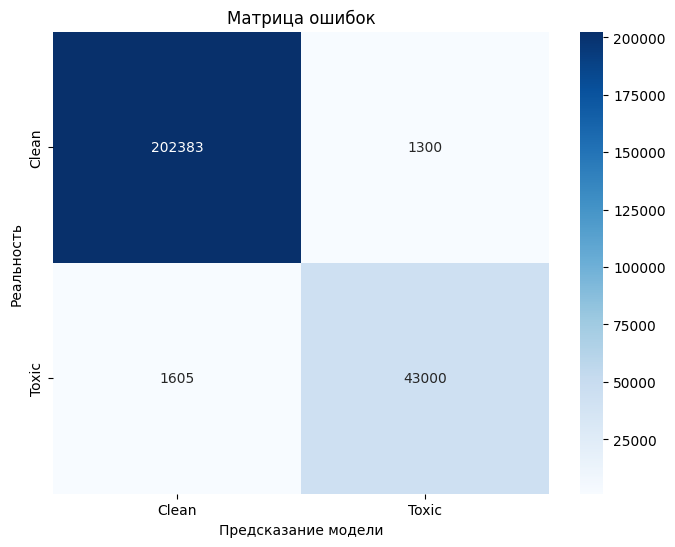

In [ ]:
cm = confusion_matrix(df_test[label_column], df_test['ai_prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.ylabel('Реальность')
plt.xlabel('Предсказание модели')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
fp_examples = df_test[(df_test[label_column] == 0) & (df_test['ai_prediction'] == 1)].head(10)

# False Negatives (FN): Реальность - Токсично (1), Предсказание - Чисто (0)
fn_examples = df_test[(df_test[label_column] == 1) & (df_test['ai_prediction'] == 0)].head(10)

print("АНАЛИЗ ОШИБОК")

print("FP:")
for i, row in fp_examples.iterrows():
    print(f"[{i}] Текст: {row[text_column][:150]}...")

print("FN:")
for i, row in fn_examples.iterrows():
    print(f"[{i}] Текст: {row[text_column][:150]}...")

errors_summary = pd.concat([fp_examples, fn_examples])
errors_summary.to_csv("/content/drive/MyDrive/Colab Notebooks/Toxic/error_analysis.csv", index=False)


АНАЛИЗ ОШИБОК
FP:
[134] Текст: ефремов подлец...
[462] Текст: в семье не без уродов...
[580] Текст: причём здесь путин путин и каспаров одного поля твари антисоветчики им обоим молчать бы так нет блять врут как дышат так что им взасос следовало бы це...
[716] Текст: крышу сноситтам кроме шуток одни дебилы собрались...
[717] Текст: вы на вопрос не ответили вам задали конкретный вопрос вы кретин...
[959] Текст: этим депутатам едросам и всем остальным их коллегам определить зплату в размере не пол миллиона а ну тысяч ведь никакой работы кроме насиживания мозол...
[1108] Текст: еська зачем стрыгется на ноль как дурачек...
[1162] Текст: это не болезнь это скотство и извращение и все это от гнилой натуры...
[1176] Текст: моя бывшая свекровьсказала однажды что лучше бы её сын женился на блядикоторая к нему клеилась раньшеона работаета я нету неё в голове не укладывалось...
[1513] Текст: я бы насильников просто уничтожала и сразу без суда и следствия много их что...
FN:
[51] Текст: украина тер